In [39]:
import pandas as pd
import string
from nltk.corpus import stopwords
import nltk
import torch
from transformers import BertTokenizer, BertModel
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt

In [29]:
# Download NLTK data if not already downloaded
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# Load the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [6]:
# Function to remove punctuation
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    text_without_punct = text.translate(translator)
    return text_without_punct

# Function to lowercase text
def lowercase_text(text):
    return text.lower()

# Function to remove stop words
def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Function to get BERT embeddings
def get_bert_embeddings(text):
    # Tokenize the text and convert it to input IDs
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    # Extract the embeddings for the [CLS] token (you can also use [CLS], [SEP], or average over all tokens)
    embeddings = outputs.last_hidden_state[:, 0, :]
    return embeddings.tolist()


In [7]:
# Read the CSV file
data = pd.read_csv('FinalDataF.csv', encoding='latin-1')


In [8]:
# Merge the 'Title' and 'Abstract' columns into a single column called 'Text'
data['Text'] = data['Title'].fillna('') + ' ' + data['Abstract'].fillna('')


In [11]:
def preprocess_and_get_embeddings(row):
    text = row['Text']

    text = remove_punctuation(text)
    text = lowercase_text(text)
    text = remove_stop_words(text)
    embeddings = get_bert_embeddings(text)

    return pd.Series({'Text_Embeddings': embeddings})

data.head()

,Title,Abstract,Text,Text_Embeddings
0,A CASE STUDY OF DRIVER'S LICENSE PROCESSES ON ...,A Case Study on Driver's License Processes was...,A CASE STUDY OF DRIVER'S LICENSE PROCESSES ON ...,"[[-0.2696315050125122, 0.4658562242984772, 0.1..."
1,A CASE STUDY ON POULTRY EGG PRODUCTION BUSINESS,A Case Study on Poultry Egg Production Busines...,A CASE STUDY ON POULTRY EGG PRODUCTION BUSINES...,"[[-0.19400064647197723, 0.14520061016082764, 0..."
2,DESIGN AND DEVELOPMENT OF A FIRE DETECTION AND...,A fire detection and alarm system prototype ba...,DESIGN AND DEVELOPMENT OF A FIRE DETECTION AND...,"[[-0.36610913276672363, 0.3781452476978302, 0...."
3,"A KNOWLEDGE-BASED SYSTEM N MATCHING TREE, PLAN...","A Knowledge-Based System on Matching of Tree, ...","A KNOWLEDGE-BASED SYSTEM N MATCHING TREE, PLAN...","[[-0.21695567667484283, 0.3216736614704132, 0...."
4,DESIGN AND DEVELOPMENT OF MEMORANDUM PRIORITIZ...,A memorandum is a means of inter-office corres...,DESIGN AND DEVELOPMENT OF MEMORANDUM PRIORITIZ...,"[[-0.7062616944313049, 0.24063676595687866, 0...."


In [10]:
# Apply the preprocessing and embedding function to each row of the DataFrame
embeddings_data = data.apply(preprocess_and_get_embeddings, axis=1)

# Concatenate the embeddings with the original DataFrame
data = pd.concat([data, embeddings_data], axis=1)

# Reshape the text embeddings to 2D
text_embeddings = np.array(data['Text_Embeddings'].tolist())


In [15]:
# Check the shape of text_embeddings
print(text_embeddings.shape)  # Should be (number_of_samples, embedding_dimension)


(380, 1, 768)


In [16]:
# Standardize the embeddings
scaler = StandardScaler()
text_embeddings_reshaped = text_embeddings.reshape(text_embeddings.shape[0], -1)
text_embeddings_scaled = scaler.fit_transform(text_embeddings_reshaped)


In [17]:
# Reduce dimensionality with PCA for efficiency
pca = PCA(n_components=0.95)  # Retain 95% of the variance
text_embeddings_pca = pca.fit_transform(text_embeddings_scaled)

In [32]:
# Use linkage and fcluster from scipy for hierarchical clustering
Z = linkage(text_embeddings_pca, method='ward')
max_d = 10  # You can adjust this threshold as needed
text_cluster_labels = fcluster(Z, max_d, criterion='distance')

# Add cluster labels to the DataFrame for text embeddings
data['Text_Cluster'] = text_cluster_labels

# Save the DataFrame with embeddings and clusters to a new CSV file
data.to_csv('clusters.csv', index=False)

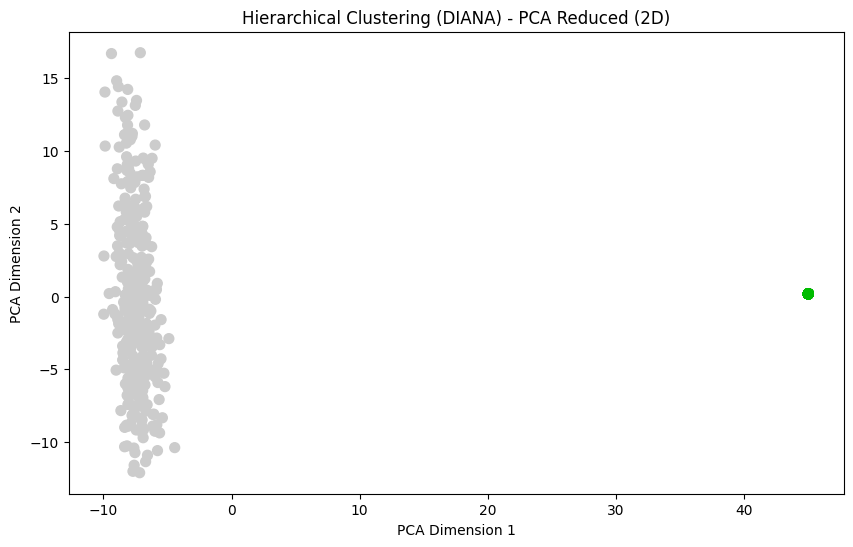

In [40]:
# Visualize the clusters using PCA for dimensionality reduction (2D)
pca = PCA(n_components=2)
text_embeddings_2d = pca.fit_transform(text_embeddings_scaled)

# Create a scatter plot to visualize clusters
plt.figure(figsize=(10, 6))
colors = plt.cm.nipy_spectral(text_cluster_labels.astype(float) / best_n_clusters)
plt.scatter(text_embeddings_2d[:, 0], text_embeddings_2d[:, 1], c=colors, marker='o', s=50)
plt.title('Hierarchical Clustering (DIANA) - PCA Reduced (2D)')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.show()